## Giancarlo's Implementation
https://github.com/giangamberi/Estudo-de-algoritmos-quanticos-e-suas-implementacoes/blob/main/EAQSI.ipynb
https://dspace.mackenzie.br/items/071a8df2-1a8f-45c2-ab22-49749d06479b

In [632]:
!pip install qiskit-aer
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit_aer
!pip install pylatexenc
!pip install tweedledum
!pip install qiskit-algorithms


In [633]:
import numpy as np
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import AerProvider, AerSimulator
from qiskit.quantum_info import Statevector

from qiskit.providers.basic_provider import BasicProvider
from qiskit.quantum_info import Statevector

from qiskit.circuit.library import DiagonalGate
from qiskit.circuit.library import Diagonal
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit.circuit.library import PhaseOracle

#plot
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import array_to_latex

# Output
outputType = "mpl"

def convertDiagonal(number, qubits):
    diagonalSize = pow(2,qubits)
    if (diagonalSize < number - 1): return -1
    aux = np.ones(diagonalSize, dtype=int) # Criacao um array do tamanho da qtd de 2 qubits
    aux[number] = -1
    return aux

def startSobreposition(qc: QuantumCircuit, qubits: list):
    for q in qubits: qc.h(q)
    return qc


# Aqui podemos imprimir o vetor de estados facilmente
def printStateVector(qc: QuantumCircuit) -> Statevector:
    qc.remove_final_measurements()  # no measurements allowed
    statevector = Statevector(qc)
    return array_to_latex(statevector, prefix="\\text{Statevector} = ")

def difusionMatrix(qc: QuantumCircuit, qubits: list, qubit_qtd: int):
    # Difusion => Hadamard . Diagonal . Hadamard
    # D = W R W
    R = np.ones(int(pow(2, len(qubits)))) # R = [1,1,1] c/ tamanho de qtd de qubits ** 2
    for i in range(1, pow(2, qubit_qtd)):
        R[i] = -1
    startSobreposition(qc, qubits)
    qc &= Diagonal(list(R))
    startSobreposition(qc, qubits)
    return qc




In [634]:
# Montagem da diagonal
qubit_qtd = 4
allQbits = [i for i in range(qubit_qtd)]

targetNumber = 1 # estado 100
groverDiagonal = list(convertDiagonal(targetNumber, qubit_qtd))
array_to_latex(groverDiagonal, prefix="\\text{Diagonal} = ")


<IPython.core.display.Latex object>

In [635]:
# Montagem do circuito inicial: Hadamard -> Diagonal


algoritmoGrover = QuantumCircuit(qubit_qtd)
algoritmoGrover = startSobreposition(algoritmoGrover, allQbits)
algoritmoGrover &= Diagonal(groverDiagonal)

# algoritmoGrover = PhaseOracle.from_dimacs_file("expressio.cnf")

print(algoritmoGrover.draw())

     ┌───┐┌───────────┐
q_0: ┤ H ├┤0          ├
     ├───┤│           │
q_1: ┤ H ├┤1          ├
     ├───┤│  Diagonal │
q_2: ┤ H ├┤2          ├
     ├───┤│           │
q_3: ┤ H ├┤3          ├
     └───┘└───────────┘


# Vetor de Estados obtido após a construção do circuito

In [636]:
printStateVector(algoritmoGrover)

<IPython.core.display.Latex object>

In [637]:
# Criação da matriz de difusão
# W R W
mtx = QuantumCircuit(qubit_qtd)
mtx.Name = "difusionMatrix"
print(difusionMatrix(mtx, allQbits, qubit_qtd))


     ┌───┐┌───────────┐┌───┐
q_0: ┤ H ├┤0          ├┤ H ├
     ├───┤│           │├───┤
q_1: ┤ H ├┤1          ├┤ H ├
     ├───┤│  Diagonal │├───┤
q_2: ┤ H ├┤2          ├┤ H ├
     ├───┤│           │├───┤
q_3: ┤ H ├┤3          ├┤ H ├
     └───┘└───────────┘└───┘


In [638]:
# Aplicando matriz de difusao de Grover ao circuito
algoritmoGrover.append(mtx, allQbits)
algoritmoGrover.measure_all()
algoritmoGrover.draw()

┌───┐┌───────────┐┌─────────────────┐ ░ ┌─┐         
   q_0: ┤ H ├┤0          ├┤0                ├─░─┤M├─────────
        ├───┤│           ││                 │ ░ └╥┘┌─┐      
   q_1: ┤ H ├┤1          ├┤1                ├─░──╫─┤M├──────
        ├───┤│  Diagonal ││  circuit-388676 │ ░  ║ └╥┘┌─┐   
   q_2: ┤ H ├┤2          ├┤2                ├─░──╫──╫─┤M├───
        ├───┤│           ││                 │ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ H ├┤3          ├┤3                ├─░──╫──╫──╫─┤M├
        └───┘└───────────┘└─────────────────┘ ░  ║  ║  ║ └╥┘
meas: 4/═════════════════════════════════════════╩══╩══╩══╩═
                                                 0  1  2  3

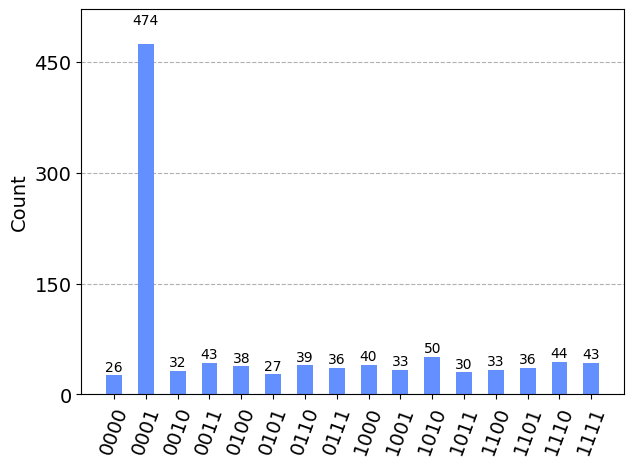

In [639]:
# Plot do resultado
backend = BasicProvider().get_backend("basic_simulator")


transpiled_algoritmoGrover = transpile(algoritmoGrover, backend)
qobj = assemble(transpiled_algoritmoGrover)
result = backend.run(transpiled_algoritmoGrover).result()
count = result.get_counts()
plot_histogram(count)

In [640]:
# # Experimentos
# from qiskit.circuit.library import GroverOperator
# from qiskit.primitives import BackendSampler
# from qiskit_algorithms import Grover



# oracle = PhaseOracle.from_dimacs_file("3sat.cnf")

# grover = GroverOperator(oracle)
# grover.decompose().draw()


# result = transpile(grover.decompose(), backend)
# job = backend.run(result)

# # sampler = BackendSampler(backend)
# # job = sampler.run(grover)

In [641]:
# Experimentos 2
# Experimentos
from qiskit.circuit.library import GroverOperator
from qiskit.primitives import BackendSampler
from qiskit.primitives import Sampler
from qiskit_algorithms import Grover, AmplificationProblem

oracle = PhaseOracle.from_dimacs_file("sat.cnf")
sampler = Sampler()

problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)
grover = Grover(sampler = sampler, iterations=2000)


In [642]:
problem.grover_operator.decompose().draw()

global phase: π
                      ┌───┐┌───┐               ┌───┐┌───┐     
state_0: ─o────────o──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├─────
          │ ┌───┐  │  ├───┤├───┤┌───┐┌───┐  │  ├───┤├───┤     
state_1: ─■─┤ X ├──■──┤ X ├┤ Z ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─────
          │ ├───┤┌───┐├───┤├───┤└───┘└───┘┌─┴─┐├───┤├───┤┌───┐
state_2: ─o─┤ Z ├┤ H ├┤ X ├┤ H ├──────────┤ X ├┤ H ├┤ X ├┤ H ├
            └───┘└───┘└───┘└───┘          └───┘└───┘└───┘└───┘

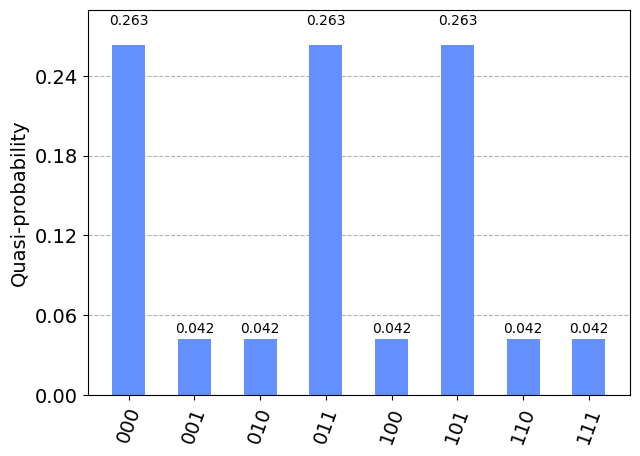

In [643]:
result = grover.amplify(problem)

if result is not None:
    display(plot_histogram(result.circuit_results))

In [644]:
problem.grover_operator.decompose().draw('mpl')
a = problem.grover_operator.decompose()
for idx, op in enumerate(a):
    print(f"Qubit {idx}: {op}")

Qubit 0: CircuitInstruction(operation=Instruction(name='ccz_o0', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'state'), 0), Qubit(QuantumRegister(3, 'state'), 2), Qubit(QuantumRegister(3, 'state'), 1)), clbits=())
Qubit 1: CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'state'), 1),), clbits=())
Qubit 2: CircuitInstruction(operation=Instruction(name='cz_o0', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'state'), 0), Qubit(QuantumRegister(3, 'state'), 1)), clbits=())
Qubit 3: CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'state'), 0),), clbits=())
Qubit 4: CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'state'), 0),), clbits=())
Qubit 5: CircuitInstruction(operation=Instruction(name='x', num_qubits=1, nu

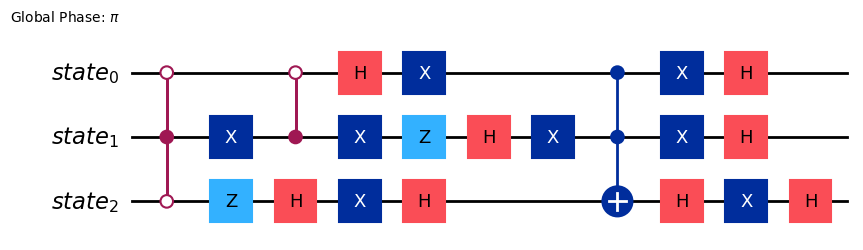

In [645]:
problem.grover_operator.decompose().draw('mpl')

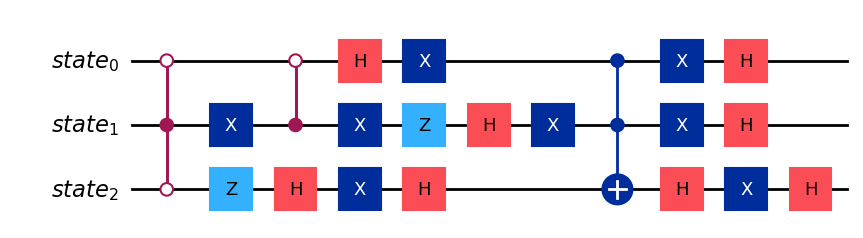

In [662]:
from qiskit import transpile, QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library import CCZGate

qr = QuantumRegister(3, "state")
qc = QuantumCircuit(qr)

# Primeiro bit

# All states

state_1 = qr[0]
state_2 = qr[1]
state_3 = qr[2]

# Coluna 1
U1 = ZGate().control(num_ctrl_qubits=2, ctrl_state='00')
qc.append(U1,qargs = [0,2,1])

# Coluna 2
qc.x(state_2)
qc.z(state_3)
qc.h(state_3)

# Coluna 3
ccz_instr = CCZGate()
U1 = ZGate().control(num_ctrl_qubits = 1, ctrl_state = '0')
qc.append(U1,qargs = [0, 1])

#Coluna 4
qc.h(state_1)
qc.x(state_2)
qc.x(state_3)

# Coluna 5
qc.x(state_1)
qc.z(state_2)
qc.h(state_3)

# Coluna 6

qc.h(state_2)

# Coluna 7
qc.x(state_2)

# Coluna 8
qc.ccx(0, 1, 2)

# Coluna 9
qc.x(state_1)
qc.x(state_2)
qc.h(state_3)

# Coluna 10
qc.h(state_1)
qc.h(state_2)
qc.x(state_3)
# Coluna 11
qc.h(state_3)

qc.draw('mpl')

In [647]:
final = oracle & qc
final.draw()

┌───┐┌───┐               ┌───┐┌───┐     
q_0: ─o───────o────────────o────────o──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├─────
      │ ┌───┐ │ ┌───┐┌───┐ │ ┌───┐  │  ├───┤├───┤┌───┐┌───┐  │  ├───┤├───┤     
q_1: ─■─┤ X ├─■─┤ X ├┤ Z ├─■─┤ X ├──■──┤ X ├┤ Z ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─────
      │ ├───┤   └───┘└───┘ │ ├───┤┌───┐├───┤├───┤└───┘└───┘┌─┴─┐├───┤├───┤┌───┐
q_2: ─o─┤ Z ├──────────────o─┤ Z ├┤ H ├┤ X ├┤ H ├──────────┤ X ├┤ H ├┤ X ├┤ H ├
        └───┘                └───┘└───┘└───┘└───┘          └───┘└───┘└───┘└───┘

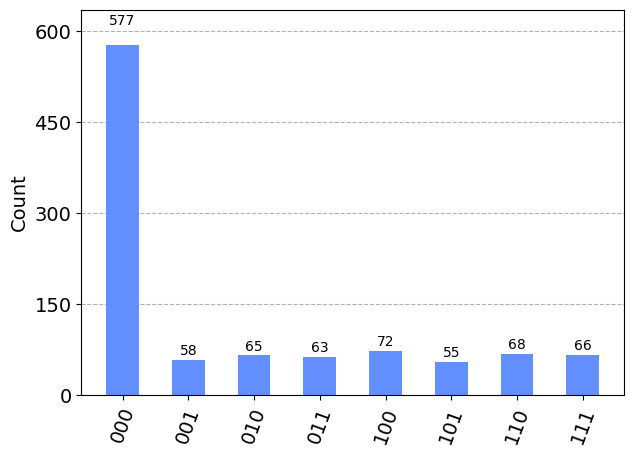

In [663]:
power = 1 # Mudar de acordo com a quantidade de iterações

grover = QuantumCircuit(problem.oracle.num_qubits, name="Grover circuit")
state_preparation = problem.state_preparation
grover.compose(state_preparation, inplace=True)
grover.compose(qc.power(power), inplace=True)
grover.draw()

measurement_cr = ClassicalRegister(len(problem.objective_qubits))
grover.add_register(measurement_cr)
grover.measure(problem.objective_qubits, measurement_cr)

In [667]:
grover.draw()

┌───┐┌─────────────────┐┌─┐      
   q_0: ┤ H ├┤0                ├┤M├──────
        ├───┤│                 │└╥┘┌─┐   
   q_1: ┤ H ├┤1 circuit-401055 ├─╫─┤M├───
        ├───┤│                 │ ║ └╥┘┌─┐
   q_2: ┤ H ├┤2                ├─╫──╫─┤M├
        └───┘└─────────────────┘ ║  ║ └╥┘
c188: 3/═════════════════════════╩══╩══╩═
                                 0  1  2

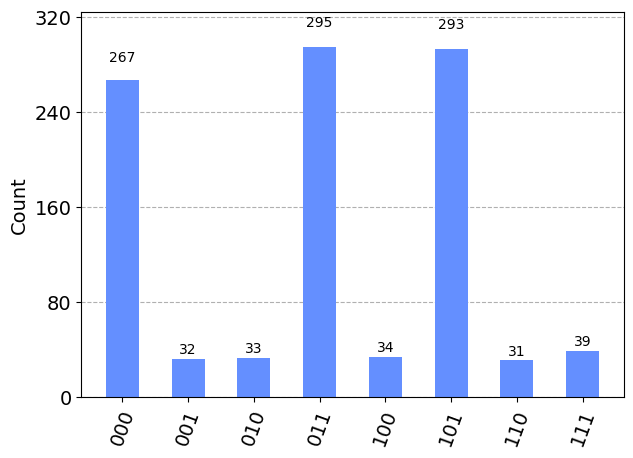

In [668]:
# Plot do resultado
backend = BasicProvider().get_backend("basic_simulator")


transpiled = transpile(grover, backend)
qobj = assemble(transpiled)
result = backend.run(transpiled).result()
count = result.get_counts()
plot_histogram(count)